<a href="https://colab.research.google.com/github/26medias/QuadrupedeIK/blob/master/Quadrupede_IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Servo-leg Inverse Kinematic

## Breakdown

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

from IPython.display import Image, display

### Variables

In [ ]:
# Physical Attributes
sideA = 4  # Upper arm
sideB = 7  # Forearm

# Physical Limits
minRadius = abs(sideA-sideB)*1.05
maxRadius = (sideA+sideB)*0.99

print("minRadius", minRadius)
print("maxRadius", maxRadius)

minRadius 3.1500000000000004
maxRadius 10.89


### Maths

In [ ]:
def normalize_angle(angle):
    # Convert the angle to a value between 0 and 360
    normalized_angle = angle % 360

    # Adjust if the original angle was negative
    if normalized_angle < 0:
        normalized_angle += 360

    return normalized_angle

def normalize_angle_180(angle):
    # Normalize the angle between -180 and 180
    normalized_angle = angle % 360
    if normalized_angle > 180:
        normalized_angle -= 360

    return normalized_angle


def restrict(point, minRadius, maxRadius):
    x, y = point
    # Calculate the current distance from the origin
    current_distance = math.sqrt(x**2 + y**2)

    # If the distance is already within the allowed range, return the original coordinates
    if minRadius <= current_distance < maxRadius:
        return x, y

    # Calculate the scale factor for the coordinates
    # If the distance is less than the minRadius, scale up to the minRadius
    # If the distance is more than the maxRadius, scale down to the maxRadius
    if current_distance < minRadius:
        scale_factor = minRadius / current_distance
    else:  # current_distance >= maxRadius
        scale_factor = maxRadius / current_distance

    # Recalculate x and y using the scale factor
    _x = x * scale_factor
    _y = y * scale_factor

    return _x, _y


print("", restrict((0,1), minRadius, maxRadius))


def getDistanceTarget(x, y, limit):
    # Calculate the distance from the origin to the point (x, y)
    length = math.sqrt(x**2 + y**2)

    # Adjust the point if the distance exceeds the limit
    if length > limit:
        scale_factor = limit / length
        _x = x * scale_factor
        _y = y * scale_factor
        adjusted_length = limit
    else:
        _x, _y = x, y
        adjusted_length = length

    # Calculate the angle between the line segment [0,0]-[_x,_y] and the vertical Y-axis
    vertical_angle_rad = math.atan2(_x, _y)  # atan2 takes y, x
    vertical_angle = math.degrees(vertical_angle_rad)
    vertical_angle = normalize_angle_180(vertical_angle)

    return adjusted_length, (_x, _y), vertical_angle

def getTriangleAngles(sideA, sideB, sideC):
    # Check if the sides can form a triangle
    if sideA + sideB <= sideC or sideA + sideC <= sideB or sideB + sideC <= sideA:
        raise ValueError("The sides do not form a triangle.")

    # Calculate the angles using the Law of Cosines and clamp the values within the range
    cos_angle_AC = max(min((sideB**2 + sideC**2 - sideA**2) / (2 * sideB * sideC), 1), -1)
    cos_angle_AB = max(min((sideC**2 + sideA**2 - sideB**2) / (2 * sideC * sideA), 1), -1)
    cos_angle_BC = max(min((sideA**2 + sideB**2 - sideC**2) / (2 * sideA * sideB), 1), -1)

    angle_AC = math.degrees(math.acos(cos_angle_AC))
    angle_AB = math.degrees(math.acos(cos_angle_AB))
    angle_BC = math.degrees(math.acos(cos_angle_BC))

    return angle_AC, angle_AB, angle_BC

def trianglePointsToAngles(pA, pB, pC):
    # Helper function to calculate distance between two points
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    # Calculate the lengths of the sides of the triangle
    side_AB = distance(pA, pB)
    side_BC = distance(pB, pC)
    side_AC = distance(pA, pC)

    # Calculate the angles using the Law of Cosines
    angle_AC = math.degrees(math.acos((side_AB**2 + side_BC**2 - side_AC**2) / (2 * side_AB * side_BC)))
    angle_AB = math.degrees(math.acos((side_AC**2 + side_BC**2 - side_AB**2) / (2 * side_AC * side_BC)))
    angle_BC = math.degrees(math.acos((side_AB**2 + side_AC**2 - side_BC**2) / (2 * side_AB * side_AC)))

    return angle_AC, angle_AB, angle_BC

def getPointB(pointA, pointC, side_lengths, side=1):
    ax, ay = pointA
    cx, cy = pointC
    sideB, sideA, sideC = side_lengths

    # Ensure triangle inequality is satisfied
    if sideA + sideB <= sideC or sideA + sideC <= sideB or sideB + sideC <= sideA:
        raise ValueError("Invalid side lengths for a triangle.")

    # Calculate the angle at point A using the Law of Cosines
    # Clamp the value between -1 and 1 to avoid math domain error
    cos_angle_A = max(min((sideB**2 + sideC**2 - sideA**2) / (2 * sideB * sideC), 1), -1)
    angle_A_rad = math.acos(cos_angle_A)

    angle_AC_direction_rad = math.atan2(cy - ay, cx - ax)

    if side == 1:
        angle_B_direction_rad = angle_AC_direction_rad - angle_A_rad
    else:
        angle_B_direction_rad = angle_AC_direction_rad + angle_A_rad

    bx = ax + sideB * math.cos(angle_B_direction_rad)
    by = ay + sideB * math.sin(angle_B_direction_rad)

    return bx, by

 (0.0, 3.1500000000000004)


### IK utility

In [ ]:
def IK(x, y):
    pointA = (0, 0)
    pointC = restrict((x, y), minRadius, maxRadius)

    maxLength = (sideA+sideB)*0.98
    sideC, coords, vertical_angle = getDistanceTarget(pointC[0], pointC[1], maxLength)
    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=1)
    #if x<=0:
    #    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=1)
    #else:
    #    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=-1)

    return (pointA, pointB, pointC)

def testIK():
  points = IK(-3, 5)
  angles = trianglePointsToAngles(points[0], points[1], points[2])
  print("points", points)
  print("angles", angles)
testIK()

points ((0, 0), (3.3850658283414763, 2.131039497004885), (-3, 5))
angles (56.38762540153382, 34.840736834978344, 88.77163776348785)


## Compact

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Physical Attributes
sideA = 6  # Upper arm
sideB = 6.5  # Forearm

# Physical Limits
minRadius = abs(sideA-sideB)*1.05
maxRadius = (sideA+sideB)*0.9999

# Normalize the angle between -180 and 180
def normalize_angle_180(angle):
    normalized_angle = angle % 360
    if normalized_angle > 180:
        normalized_angle -= 360

    return normalized_angle

# Apply enveloppe restrictions on input coordinates
def restrictMovements(point):
    x, y = point
    # Calculate the current distance from the origin
    current_distance = math.sqrt(x**2 + y**2)

    # If the distance is already within the allowed range, return the original coordinates
    if minRadius <= current_distance < maxRadius:
        return x, y

    # Calculate the scale factor for the coordinates
    # If the distance is less than the minRadius, scale up to the minRadius
    # If the distance is more than the maxRadius, scale down to the maxRadius
    if current_distance < minRadius:
        scale_factor = minRadius / current_distance
    else:  # current_distance >= maxRadius
        scale_factor = maxRadius / current_distance

    # Recalculate x and y using the scale factor
    _x = x * scale_factor
    _y = y * scale_factor
    return _x, _y


# Calculate the distance from the origin to the point (x, y)
def getDistanceTarget(x, y, limit):
    length = math.sqrt(x**2 + y**2)

    # Adjust the point if the distance exceeds the limit
    if length > limit:
        scale_factor = limit / length
        _x = x * scale_factor
        _y = y * scale_factor
        adjusted_length = limit
    else:
        _x, _y = x, y
        adjusted_length = length

    return adjusted_length, (_x, _y)


def trianglePointsToAngles(pA, pB, pC):
    # Helper function to calculate distance between two points
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    # Calculate the lengths of the sides of the triangle
    side_AB = distance(pA, pB)
    side_BC = distance(pB, pC)
    side_AC = distance(pA, pC)

    # Calculate the angles using the Law of Cosines
    angle_AC = math.degrees(math.acos((side_AB**2 + side_BC**2 - side_AC**2) / (2 * side_AB * side_BC)))
    angle_AB = math.degrees(math.acos((side_AC**2 + side_BC**2 - side_AB**2) / (2 * side_AC * side_BC)))
    angle_BC = math.degrees(math.acos((side_AB**2 + side_AC**2 - side_BC**2) / (2 * side_AB * side_AC)))

    return angle_AC, angle_AB, angle_BC

def getPointB(pointA, pointC, side_lengths, side=1):
    ax, ay = pointA
    cx, cy = pointC
    sideB, sideA, sideC = side_lengths

    # Ensure triangle inequality is satisfied
    if sideA + sideB <= sideC or sideA + sideC <= sideB or sideB + sideC <= sideA:
        raise ValueError("Invalid side lengths for a triangle.")

    # Calculate the angle at point A using the Law of Cosines
    # Clamp the value between -1 and 1 to avoid math domain error
    cos_angle_A = max(min((sideB**2 + sideC**2 - sideA**2) / (2 * sideB * sideC), 1), -1)
    angle_A_rad = math.acos(cos_angle_A)

    angle_AC_direction_rad = math.atan2(cy - ay, cx - ax)

    if side == 1:
        angle_B_direction_rad = angle_AC_direction_rad - angle_A_rad
    else:
        angle_B_direction_rad = angle_AC_direction_rad + angle_A_rad

    bx = ax + sideB * math.cos(angle_B_direction_rad)
    by = ay + sideB * math.sin(angle_B_direction_rad)

    return bx, by

def IK(x, y):
    pointA = (0, 0)
    pointC = restrictMovements((x, y))

    maxLength = (sideA+sideB)*0.98
    sideC, coords = getDistanceTarget(pointC[0], pointC[1], maxLength)
    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=1)
    #if x<=0:
    #    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=1)
    #else:
    #    pointB = getPointB(pointA, pointC, (sideA, sideB, sideC), side=-1)

    return (pointA, pointB, pointC)

def testIK():
  points = IK(-3, 5)
  angles = trianglePointsToAngles(points[0], points[1], points[2])

  shoulderAngle = math.atan2(points[1][0], points[1][1])
  shoulderAngle = math.degrees(shoulderAngle)

  print("points", points)
  print("shoulderAngle", shoulderAngle)
  print("angles", angles)
  print("------------")
  print(getDistanceTarget(-10,10,12))

def test(x, y):
  points = IK(x, y)
  print("Point A:", points[0])
  print("Point B:", points[1])
  print("Point C:", points[2])

test(-5, -5)


Point A: (0, 0)
Point B: (-5.822722654803966, 1.4477226548039677)
Point C: (-5, -5)


## Render

### Static Image

points ((0, 0), (-5.739583333333333, 1.7484802428744302), (-12, 0))
angles (147.45281951213, 15.604588878442495, 16.942591609427538)
------------
Shoulder Angle -73.05740839057246
Elbow Angle 147.45281951213


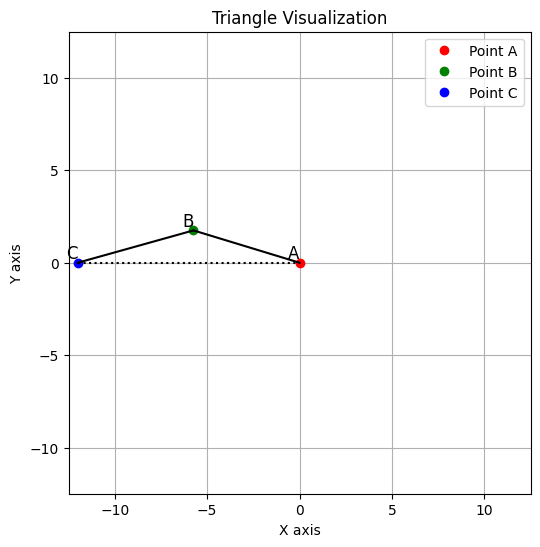

In [ ]:
def renderTriangle(points, range_value):
    # Create a square figure with equal aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # You can adjust the figure size as needed

    # Unpack the points
    pointA, pointB, pointC = points

    # Plot the points and label them
    ax.plot(*pointA, 'ro', label='Point A')
    ax.text(pointA[0], pointA[1], 'A', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    ax.plot(*pointB, 'go', label='Point B')
    ax.text(pointB[0], pointB[1], 'B', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    ax.plot(*pointC, 'bo', label='Point C')
    ax.text(pointC[0], pointC[1], 'C', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    # Draw lines (segments) between the points to form the triangle
    ax.plot([pointA[0], pointB[0]], [pointA[1], pointB[1]], 'k-')  # A-B
    ax.plot([pointB[0], pointC[0]], [pointB[1], pointC[1]], 'k-')  # B-C
    ax.plot([pointC[0], pointA[0]], [pointC[1], pointA[1]], 'k:')  # C-A less visible

    # Set the range for the axes
    ax.set_xlim(-range_value, range_value)
    ax.set_ylim(-range_value, range_value)

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal', 'box')

    # Add grid, legend, and labels
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Triangle Visualization')

    # Show the plot
    plt.show()

def testRenderTriangle():
  points = IK(-12, 0)
  angles = trianglePointsToAngles(points[0], points[1], points[2])

  shoulderAngle = math.atan2(points[1][0], points[1][1])
  shoulderAngle = math.degrees(shoulderAngle)

  print("points", points)
  print("angles", angles)
  print("------------")
  print("Shoulder Angle", shoulderAngle)
  print("Elbow Angle", angles[0])

  renderTriangle(points, sideA+sideB)

testRenderTriangle()

### Animation

[((0, 0), (-5.684605246071199, 1.9197039345533988), (-3.0, -4.0)), ((0, 0), (-5.700092939047124, 1.8732166148700258), (-2.915254237288136, -4.0)), ((0, 0), (-5.715876731342924, 1.8244871038438533), (-2.830508474576271, -4.0)), ((0, 0), (-5.731912240769714, 1.7734661158630343), (-2.7457627118644066, -4.0)), ((0, 0), (-5.748150816001884, 1.7201052864568704), (-2.6610169491525424, -4.0)), ((0, 0), (-5.764539363161729, 1.664357512843608), (-2.576271186440678, -4.0)), ((0, 0), (-5.7810201867184645, 1.606177325438758), (-2.4915254237288136, -4.0)), ((0, 0), (-5.797530848599893, 1.5455212905465316), (-2.406779661016949, -4.0)), ((0, 0), (-5.81400404975662, 1.4823484439947394), (-2.3220338983050848, -4.0)), ((0, 0), (-5.830367538732138, 1.41662075493004), (-2.2372881355932206, -4.0)), ((0, 0), (-5.846544052062376, 1.3483036183642199), (-2.152542372881356, -4.0)), ((0, 0), (-5.862451291539291, 1.2773663743536177), (-2.0677966101694913, -4.0)), ((0, 0), (-5.878001943506242, 1.203782850906608), (

<ipython-input-7-02d0b9a78c5c>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pointA[0], pointC[0]], [pointA[1], pointC[1]], 'k:', color='gray')


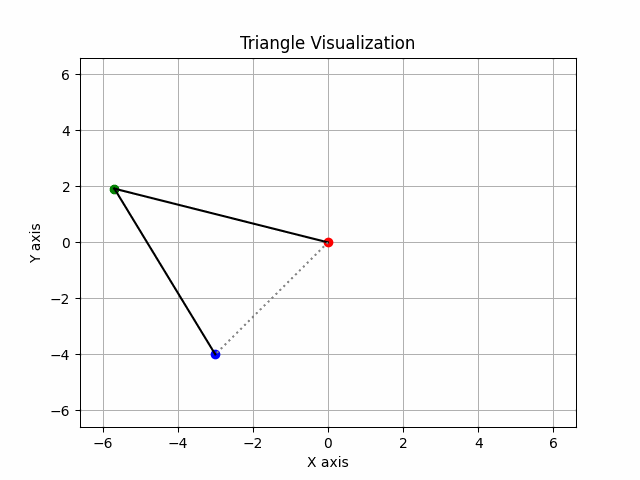

In [ ]:

def generateKeyframes(start, end, n, minRadius, maxRadius):
    x0, y0 = start
    x1, y1 = end

    step_x = (x1 - x0) / (n - 1)
    step_y = (y1 - y0) / (n - 1)

    keyframes = []

    for i in range(n):
        x = x0 + step_x * i
        y = y0 + step_y * i
        triangle_points = IK(x, y) # returns ((x0,y0),(x1,y1),(x2,y2)) representing a triangle
        keyframes.append(triangle_points)

    return keyframes

def render_frame(ax, points, range_value):
    """
    Render a frame for the animation with given points and specified range for the axes.
    """
    # Clear the previous frame
    ax.clear()

    # Unpack the points
    pointA, pointB, pointC = points

    # Plot the points and draw lines between them to form the triangle
    ax.plot(*pointA, 'ro')  # Point A
    ax.plot(*pointB, 'go')  # Point B
    ax.plot(*pointC, 'bo')  # Point C

    # Draw segments A-B and B-C with solid black lines
    ax.plot([pointA[0], pointB[0]], [pointA[1], pointB[1]], 'k-')
    ax.plot([pointB[0], pointC[0]], [pointB[1], pointC[1]], 'k-')

    # Draw segment A-C with a gray dotted line to indicate less visibility
    ax.plot([pointA[0], pointC[0]], [pointA[1], pointC[1]], 'k:', color='gray')

    # Set the range for the axes
    ax.set_xlim(-range_value, range_value)
    ax.set_ylim(-range_value, range_value)

    # Set up the grid, legend, and labels
    ax.grid(True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Triangle Visualization')

def generateGif(output_filename, keyframes, fps=20):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Calculate the range value based on the maximum side length in the keyframes
    range_value = max(max(abs(coord) for point in frame for coord in point) for frame in keyframes) * 1.1

    # Initialize the plot to set labels and grid which won't change
    ax.grid(True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Triangle Visualization')
    ax.set_xlim(-range_value, range_value)
    ax.set_ylim(-range_value, range_value)

    # Function to update each frame in the animation
    def update(frame):
        render_frame(ax, frame, range_value)
        return ax,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=keyframes, blit=False, interval=1000/fps)

    # Save the animation
    ani.save(output_filename, writer='pillow', fps=fps)

    # Close the plot
    plt.close()


startPoint = (-3, -4)
endPoint = (2, -4)

number_of_points = 60

keyframes = generateKeyframes(startPoint, endPoint, number_of_points, minRadius, maxRadius)
print(keyframes)

# Example usage
generateGif('triangle_animation.gif', keyframes, fps=20)
display(Image(filename='triangle_animation.gif'))

### Multi-frames

[((0, 0), (-5.684605246071199, 1.9197039345533988), (-3.0, -4.0)), ((0, 0), (-5.700092939047124, 1.8732166148700258), (-2.915254237288136, -4.0)), ((0, 0), (-5.715876731342924, 1.8244871038438533), (-2.830508474576271, -4.0)), ((0, 0), (-5.731912240769714, 1.7734661158630343), (-2.7457627118644066, -4.0)), ((0, 0), (-5.748150816001884, 1.7201052864568704), (-2.6610169491525424, -4.0)), ((0, 0), (-5.764539363161729, 1.664357512843608), (-2.576271186440678, -4.0)), ((0, 0), (-5.7810201867184645, 1.606177325438758), (-2.4915254237288136, -4.0)), ((0, 0), (-5.797530848599893, 1.5455212905465316), (-2.406779661016949, -4.0)), ((0, 0), (-5.81400404975662, 1.4823484439947394), (-2.3220338983050848, -4.0)), ((0, 0), (-5.830367538732138, 1.41662075493004), (-2.2372881355932206, -4.0)), ((0, 0), (-5.846544052062376, 1.3483036183642199), (-2.152542372881356, -4.0)), ((0, 0), (-5.862451291539291, 1.2773663743536177), (-2.0677966101694913, -4.0)), ((0, 0), (-5.878001943506242, 1.203782850906608), (

<ipython-input-7-02d0b9a78c5c>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pointA[0], pointC[0]], [pointA[1], pointC[1]], 'k:', color='gray')


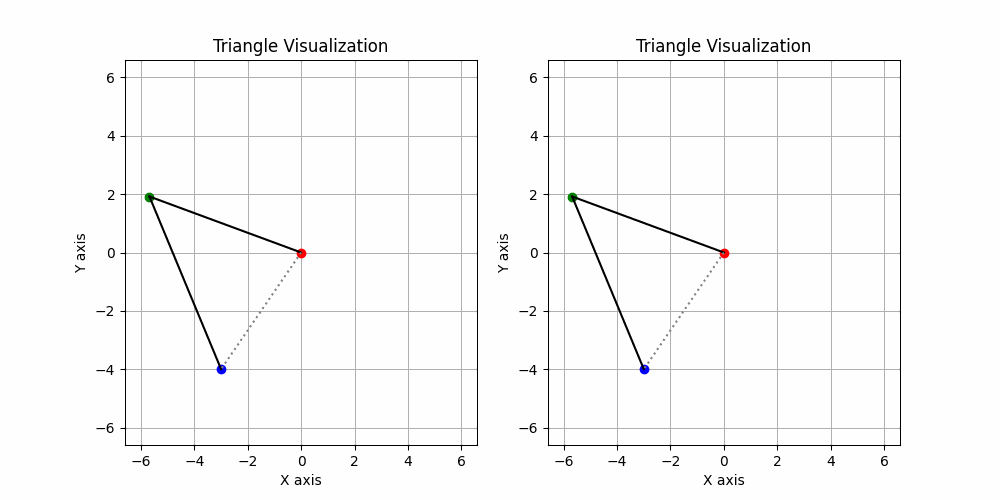

In [ ]:
def generateGifMany(output_filename, keyframes_list, fps=20):
    # Determine the number of rows for the subplot grid (2 columns)
    num_rows = int(np.ceil(len(keyframes_list) / 2))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 5))

    # Flatten the axes array for easy indexing
    axes_flat = axes.flatten()

    # Calculate the range value for all subplots (assuming same range for all)
    range_value = max(max(max(abs(coord) for point in frame for coord in point) for frame in keyframes) * 1.1 for keyframes in keyframes_list)

    # Initialize each subplot
    for ax in axes_flat:
        ax.grid(True)
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_title('Triangle Visualization')
        ax.set_xlim(-range_value, range_value)
        ax.set_ylim(-range_value, range_value)

    # Function to update each frame in the animation
    def update(frame_idx):
        for i, keyframes in enumerate(keyframes_list):
            if frame_idx < len(keyframes):
                render_frame(axes_flat[i], keyframes[frame_idx], range_value)
            else:
                # Clear or hide the subplot if there are no more frames for this keyframes set
                axes_flat[i].clear()
                axes_flat[i].set_axis_off()
        return axes_flat

    # Max number of frames in the keyframes
    max_frames = max(len(kf) for kf in keyframes_list)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=max_frames, blit=False, interval=1000/fps)

    # Save the animation
    ani.save(output_filename, writer='pillow', fps=fps)

    # Close the plot
    plt.close()



startPoint = (-3, -4)
endPoint = (2, -4)

number_of_points = 60

keyframes = generateKeyframes(startPoint, endPoint, number_of_points, minRadius, maxRadius)
print(keyframes)

# Example usage
generateGifMany('triangle_animation.gif', [keyframes, keyframes], fps=20)
display(Image(filename='triangle_animation.gif'))

## Gait

### Original code

Credit: https://github.com/ger01d/kinematic-model-opencat

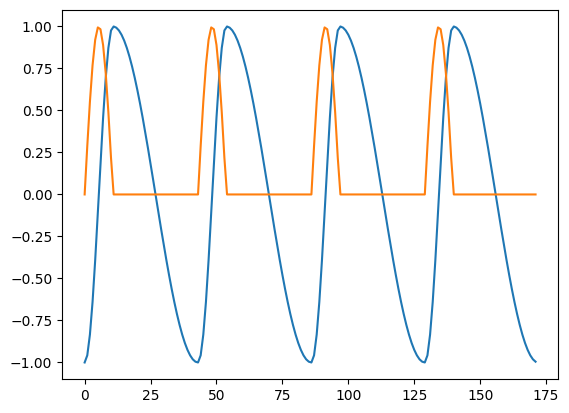

In [ ]:
from numpy import sin, cos, pi

# Credit https://github.com/ger01d/kinematic-model-opencat
def buildGait(frames):
    frame = np.arange(0,frames)
    swingEnd = pi/2

    # longitudinal Movement
    swing = -cos(2*(frame*2*pi/frames))
    stance = cos(2/3*(frame*2*pi/frames-swingEnd))
    swingSlice = np.less_equal(frame,swingEnd/(2*pi/frames))
    stanceSlice = np.invert(swingSlice)
    longitudinalMovement = np.concatenate((swing[swingSlice], stance[stanceSlice]))
    longitudinalMovement = np.concatenate((longitudinalMovement,longitudinalMovement, longitudinalMovement, longitudinalMovement))

    # vertical Movement
    lift = sin(2*(frame*2*pi/frames))
    liftSlice = swingSlice
    verticalMovement = np.concatenate((lift[liftSlice], np.zeros(np.count_nonzero(stanceSlice))))
    verticalMovement = np.concatenate((verticalMovement, verticalMovement, verticalMovement, verticalMovement))
    return longitudinalMovement, verticalMovement


frames = 43
longitudinalMovement, verticalMovement = buildGait(frames)
plt.plot(longitudinalMovement)
plt.plot(verticalMovement)
plt.show()
# print("longitudinalMovement:")
# print(longitudinalMovement)
# print("verticalMovement:")
# print(verticalMovement)

### Frame by frame

0  ->  -1.0 0.0
1  ->  -0.9774033898178667 0.21138262362962432
2  ->  -0.9106347728549132 0.41321218576837815
3  ->  -0.8027116379309637 0.5963673585385013
4  ->  -0.6585113790650386 0.7525707698561385
5  ->  -0.4845508703326502 0.8747630845319613
6  ->  -0.28869194733962117 0.9574220383620055
7  ->  -0.0797861055530831 0.9968120070307501
8  ->  0.13272552728372186 0.9911528310040072
9  ->  0.33923886611803006 0.9407002666710333
10  ->  0.5304209081197424 0.847734427889671
11  ->  0.6976315211349846 0.7164567402983153
12  ->  0.8333139190825148 0.5528000653611936
13  ->  0.9313361774523383 0.3641605752528225
14  ->  0.9872683547213446 0.1590634960190721
15  ->  0.9998424886638378 0.0
16  ->  0.9960646970310025 0.0
17  ->  0.9872683547213446 0.0
18  ->  0.9734977810343867 0.0
19  ->  0.9548223573286919 0.0
20  ->  0.9313361774523384 0.0
21  ->  0.9031575736625237 0.0
22  ->  0.8704285204228972 0.0
23  ->  0.8333139190825151 0.0
24  ->  0.792000767040474 0.0
25  ->  0.7466972155822879 0.

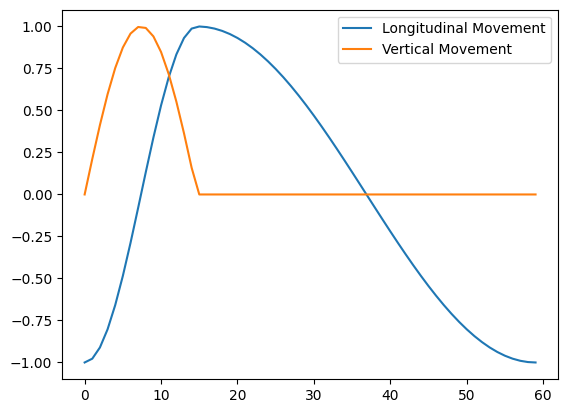

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def buildGaitFrame(frames, frame_number):
    # Ensure frame_number is within the valid range
    frame_number = frame_number % frames
    swingEnd = np.pi / 2

    # Time array for the full gait cycle
    time_array = np.linspace(0, 2 * np.pi, frames)

    # Longitudinal Movement
    swing = -np.cos(2 * time_array)
    stance = np.cos((2/3) * (time_array - swingEnd))
    swingSlice = np.less_equal(time_array, swingEnd)
    stanceSlice = np.invert(swingSlice)
    longitudinalMovement = np.where(swingSlice, swing, stance)

    # Vertical Movement
    lift = np.sin(2 * time_array)
    verticalMovement = np.where(swingSlice, lift, 0)

    # Return only the specified frame
    return longitudinalMovement[frame_number], verticalMovement[frame_number]

def generateAllGaitFrames(frames):
    longitudinal_movements = []
    vertical_movements = []

    for n, frame_number in enumerate(range(frames)):
        longitudinal, vertical = buildGaitFrame(frames, frame_number)
        print(n, " -> ", longitudinal, vertical)
        longitudinal_movements.append(longitudinal)
        vertical_movements.append(vertical)

    return longitudinal_movements, vertical_movements

# Use the function to generate all frames
frames = 60  # Total number of frames in the gait cycle
longitudinal_movements, vertical_movements = generateAllGaitFrames(frames)

# Now you can plot all the frames to visualize the gait
plt.plot(longitudinal_movements, label='Longitudinal Movement')
plt.plot(vertical_movements, label='Vertical Movement')
plt.legend()
plt.show()


### Quadrupede Gait

0 0.0
1 5.0
2 10.0
3 15.0


<ipython-input-7-02d0b9a78c5c>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pointA[0], pointC[0]], [pointA[1], pointC[1]], 'k:', color='gray')


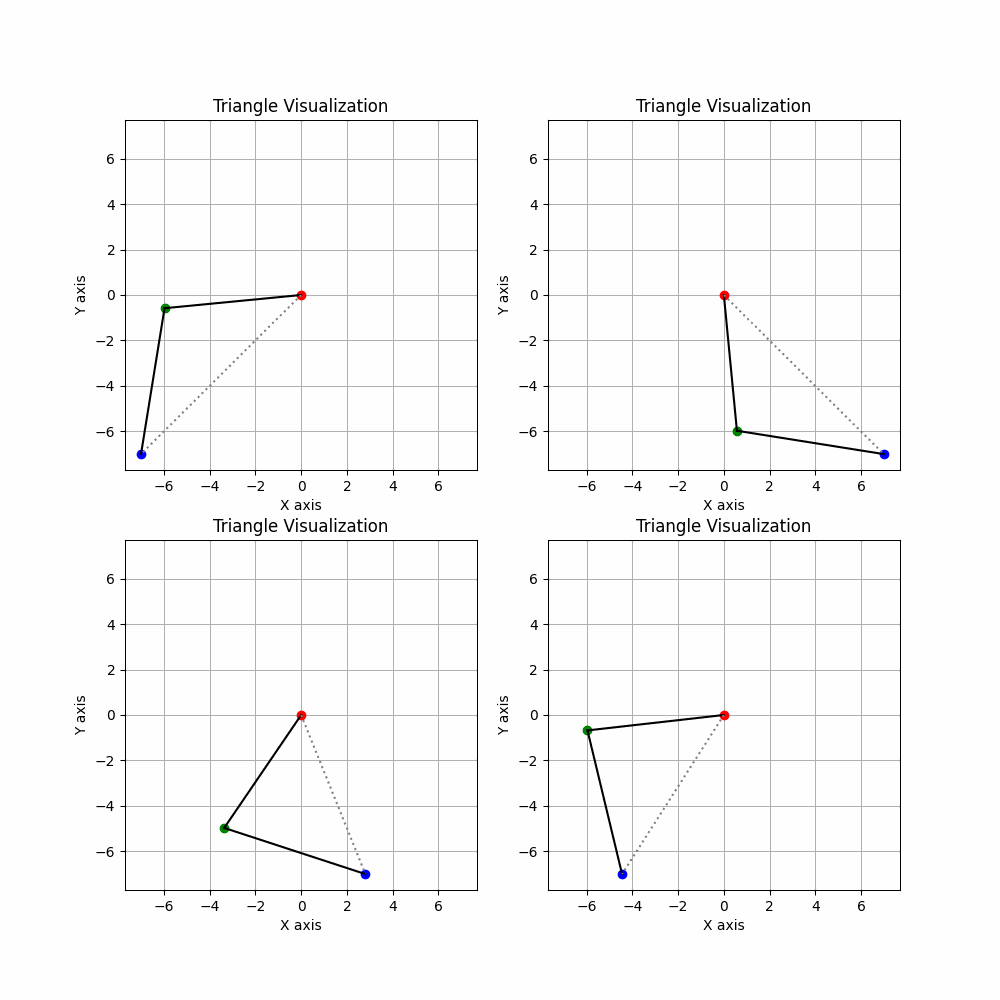

In [ ]:
def getKeyframes(cycle_length=20, ground_distance=-5, radius=7, step_height=1, offset=0):
  keyframes = []
  k_offset = (cycle_length/4)*offset
  print(offset, k_offset)
  for i in range(0,cycle_length):
    x, y = buildGaitFrame(cycle_length, math.floor((i+k_offset)) % cycle_length)
    triangle_points = IK(x*radius, ground_distance+(y*step_height))
    keyframes.append(triangle_points)
  return keyframes

step_radius = 5
step_height = 7
frames1 = getKeyframes(cycle_length=20, ground_distance=-7, radius=step_radius, step_height=step_height)
frames2 = getKeyframes(cycle_length=20, ground_distance=-7, radius=step_radius, step_height=step_height, offset=1)
frames3 = getKeyframes(cycle_length=20, ground_distance=-7, radius=step_radius, step_height=step_height, offset=2)
frames4 = getKeyframes(cycle_length=20, ground_distance=-7, radius=step_radius, step_height=step_height, offset=3)
generateGifMany('gait_animation.gif', [frames1, frames2, frames3, frames4], fps=15)
display(Image(filename='gait_animation.gif'))
